# Model training

## Import libraries

The following command must be executed for balancing:

```conda install -c conda-forge imbalanced-learn```

In [2]:
%pip install -q -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import BernoulliRBM

import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import math

In [2]:
# Tensorflow may not be installed on every system

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

## Methods

In [29]:
def truncate(number, digits) -> float:
    # Helper method that truncate scores to four decimals
    nbDecimals = len(str(number).split('.')[1])
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper


def get_nested(data, *args):
    # Helper method that returns the value of a nested dictionary
    if args and data:
        element  = args[0]
        if element:
            value = data.get(element)
            return value if len(args) == 1 else get_nested(value, *args[1:])
    return None


def get_scores(y_test, y_predicted):
    # Method that returns different scores for the passed parameters
    digits = 4
    scores = {
        'Accuracy': truncate(accuracy_score(y_test, y_predicted), digits),
        'Recall': truncate(recall_score(y_test, y_predicted), digits),
        'Precision': truncate(precision_score(y_test, y_predicted), digits),
        'F1 score': truncate(f1_score(y_test, y_predicted), digits),
        'F2 score': truncate(fbeta_score(y_test, y_predicted, beta=2), digits)
    }
    return scores


def print_scores(all_scores):
    # Method that prints a table of the passed scores
    header_row = "{header:<20}".format(header="Estimator")
    for score in list(all_scores.values())[0]:
        header_row+="{header:>15}".format(header=score)
    print(header_row,"\n")

    for estimator in all_scores.keys():
        current_row = "{estimator:<20}".format(estimator=estimator)
        estimator_scores = all_scores.get(estimator)
        for score in estimator_scores:
            score_value = get_nested(all_scores, estimator, score)
            current_row+="{score_value:>15}".format(score_value=score_value)
        print(current_row)
        

def print_best_params(estimator_params):
    # Method that prints the best parameters
    for estimator in estimator_params.keys():
        print("Best parameters for "+estimator+": ")
        parameters = estimator_params.get(estimator)
        for parameter in parameters:
            print(parameter+": "+str(get_nested(estimator_params, estimator, parameter)))
            

def plot_roc(title, ax, y_test, y_predicted):
    # Method that plots the ROC for the passed parameters
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

    ax.set_title('Receiver Operating Characteristic (ROC) - '+title)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    

def plot_feature_importance(title, ax, estimator, X_train):
    # Method that plots the feature importance for the passed parameters
    feat_importance = pd.Series(estimator.feature_importances_, index=X_train.columns)
    feat_importance.nlargest(12).plot(kind='barh', ax=ax)

    ax.set_title('Feature Importance for '+title)


def plot_learning_curve(title, estimator, ax, X, y, cv, scoring):
    # Method that plots the learning curve for the passed parameters
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=4,
        train_sizes=np.linspace(0.1, 1.0, 5),
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

    ax.set_title("Learning Curve: "+title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend()
    

def model_evaluate(estimator, parameters, X_train, X_test, y_train, y_test):
    # Method that trains the passed model with the passed parameters and plots the evaluation of it
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    scoring = make_scorer(fbeta_score, beta=2)

    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator.value,
                                         param_grid=parameters,
                                         scoring= scoring,
                                         cv=cv,
                                         return_train_score=False,
                                         verbose=0,
                                         n_jobs=2
                                         )
    # training and prediction
    grid_search_estimator.fit(X_train, y_train)
    y_predicted = grid_search_estimator.predict(X_test)

    # evaluation of the model
    # TODO BL: @FL @JG should we use cross validation?
    print_scores({estimator.name: get_scores(y_test, y_predicted)})
    print_best_params({estimator.name: grid_search_estimator.best_params_})

    figure = plt.figure(figsize=(15, 15))
    figure_index = 1
    number_of_rows = 2
    number_of_columns = 2

    # plot roc
    ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
    plot_roc(title=estimator.name, ax=ax, y_test=y_test, y_predicted=y_predicted)
    figure_index += 1

    # plot feature importance in case of forest estimator
    if estimator==Estimator.forest_estimator:
        ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_feature_importance(title=estimator.name, ax=ax, estimator=grid_search_estimator.best_estimator_, X_train=X_train)
        figure_index += 1

    # plot learning curve in case of nn estimator
    if estimator==Estimator.nn_estimator:
        ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_learning_curve(title=estimator.name, estimator=estimator.value, ax=ax, X=X_train, y=y_train, cv=cv, scoring=scoring)
        figure_index += 1

    plt.show()

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [23]:
# Load dataset
heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')

# Split and reduce dataset (reduction only for test purposes)
X = heart_dataset.drop(columns='HeartDisease')
y = heart_dataset['HeartDisease']
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.999, random_state = 42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42, stratify=y_train)

# Balance training data
X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

data_dict = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
X_train

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,...,SleepTime,Asthma,KidneyDisease,SkinCancer,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,0.432331,0,0,0,0.000000,0.000000,0,1,62,1.000000,...,0.304348,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.197030,0,0,0,0.000000,0.000000,0,1,21,0.000000,...,0.304348,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.149101,1,1,0,0.000000,0.000000,0,0,37,0.000000,...,0.260870,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.147169,0,0,0,0.133333,0.000000,0,1,72,0.000000,...,0.304348,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.203791,0,0,0,0.000000,0.000000,0,1,90,0.000000,...,0.304348,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0.171918,0,0,0,0.000000,0.000000,0,1,52,0.000000,...,0.347826,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0
462,0.270675,1,0,0,0.000000,0.000000,0,0,72,0.000000,...,0.304348,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
463,0.301099,1,0,0,0.133333,0.133333,1,0,62,1.000000,...,0.173913,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0
464,0.219969,0,0,0,0.000000,0.000000,1,0,57,1.000000,...,0.304348,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

Dummy Classifier             0.6406            0.2           0.05           0.08          0.125


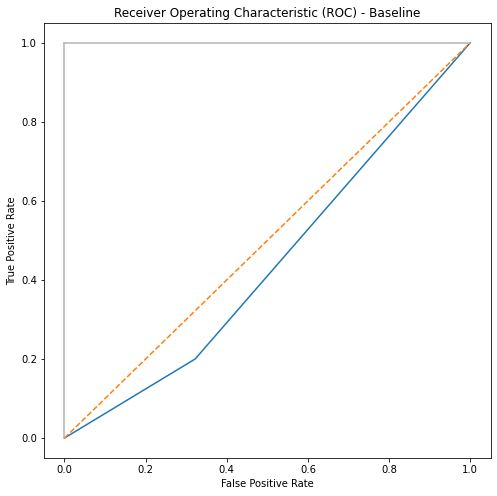

In [24]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)

print_scores({'Dummy Classifier':get_scores(y_test, y_predicted)})
plot_roc(title='Baseline', ax=plt.figure(figsize=(8, 8)).add_subplot(), y_test=y_test, y_predicted=y_predicted)
plt.show()

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Model selection

To find out which modeling method with which parameters best fits to our task, we define a set of modeling methods, train them with different parameters (hyperparameter tuning) and evaluate the results.

In [25]:
# Create DNN model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(30, input_shape=(X_train.columns.size,), activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Enumeration class containing all estimators we want to consider for classification
class Estimator(Enum):
    knn_estimator=KNeighborsClassifier()
    nn_estimator=MLPClassifier(random_state=1)
    forest_estimator=RandomForestClassifier()
    svc_estimator=SVC(random_state=0)
    dnn_estimator=KerasClassifier(model=create_model, verbose=0)

# TODO JG: Adjust nn parameters
# Dictionary of parameter grids of the estimators
param_grids = {
    Estimator.knn_estimator: {
        'n_neighbors': [2, 3, 4, 5]
    },
    Estimator.forest_estimator: {
        'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}, {0:2, 1:1}],
        'n_estimators': [20, 50, 100, 200, 400, 800, 1000]
    },
    Estimator.svc_estimator: {
        'kernel': ['linear', 'poly']
    },
    Estimator.nn_estimator: {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'hidden_layer_sizes': [(100), (150,100,50), (120,80,40), (100,50,30)],
        'max_iter': [300, 400, 500, 600],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    },
    Estimator.dnn_estimator: {
        'batch_size': [16, 32, 64],
        'epochs': [1, 2, 5, 10]
    }
}

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

dnn_estimator                0.0937            1.0         0.0793          0.147         0.3012
Best parameters for dnn_estimator: 
batch_size: 32
epochs: 2


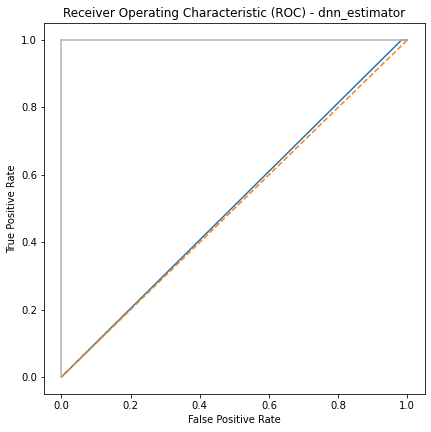

In [30]:
# dnn estimator
estimator = Estimator.dnn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

knn_estimator                0.8746         0.2189         0.2429         0.2303         0.2233
Best parameters for knn_estimator: 
n_neighbors: 2


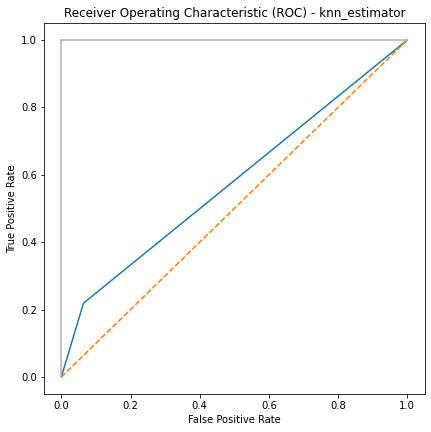

In [9]:
# knn estimator
estimator = Estimator.knn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)
plt.show()

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

forest_estimator             0.9102         0.1824         0.4424         0.2583         0.2067
Best parameters for forest_estimator: 
class_weight: {0: 1, 1: 2}
n_estimators: 800


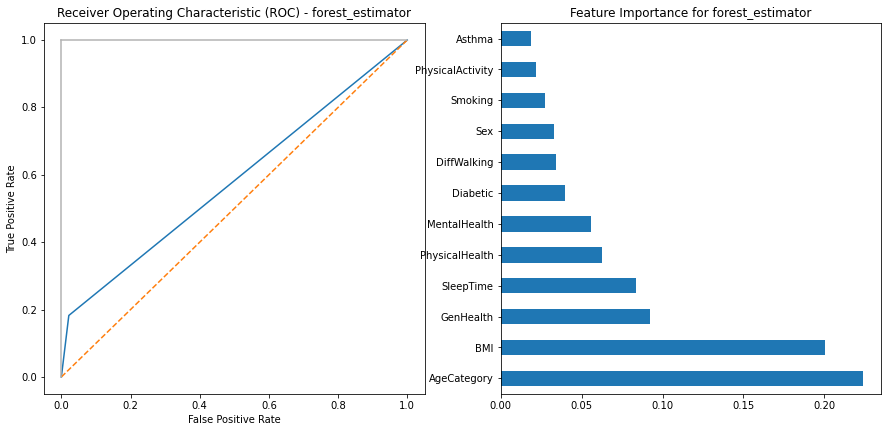

In [13]:
# random forest estimator
estimator = Estimator.forest_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [8]:
# nn estimator
estimator = Estimator.nn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

KeyboardInterrupt: 

In [25]:
# svc estimator
# estimator = Estimator.svc_estimator
# model_evaluate(estimator, param_grids.get(estimator), **data_dict)

**Conclusion**

TODO: Add conclusion

## Final model

After having determined the best model and the best parameters for it in the step of model selection, we now apply this in the following.

In [26]:
## TODO implement